In [14]:
%load_ext autoreload
%autoreload 2

import syft as sy
from utils import *
from syft import NewDataSubject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl is already downloaded
Columns: Index(['patient_ids', 'labels', 'images'], dtype='object')
Total Images: 2775
Label Mapping {'Non-Invasive Ductal Carcinoma (IDC)': 0, 'Invasive Ductal Carcinoma (IDC)': 1}


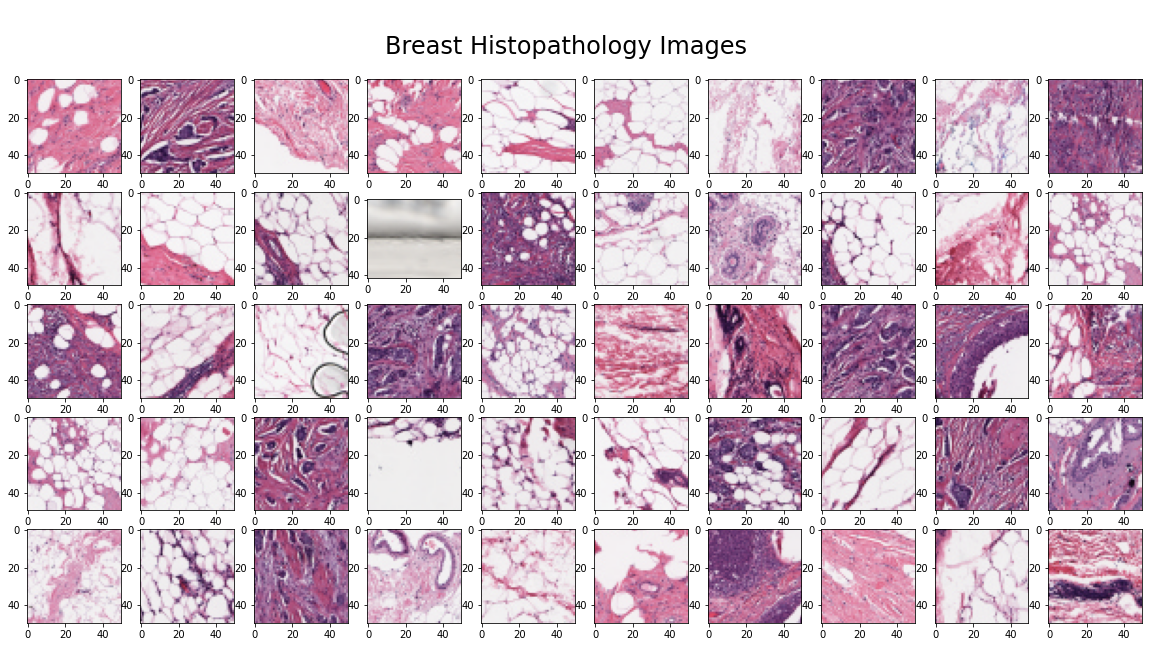

In [15]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/BreastCancerDataset/subsets/BreastCancerDataset-02ec48b840824b1ea3e1f5d11c45314b.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [16]:
dataset.head()

,patient_ids,labels,images
0,22545,0,"[[[223, 204, 216], [238, 234, 238], [234, 228,..."
1,22545,0,"[[[205, 100, 129], [197, 86, 122], [188, 80, 1..."
2,22545,0,"[[[227, 205, 215], [204, 143, 176], [218, 169,..."
3,22545,0,"[[[239, 227, 230], [234, 197, 214], [240, 229,..."
4,22545,0,"[[[234, 221, 227], [234, 218, 227], [240, 238,..."


In [17]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (2234, 3, 50, 50)
Dims (268, 3, 50, 50)
Dims (273, 3, 50, 50)
Preprocessing completed.


In [18]:
# run this cell
data_subjects_image = np.ones(train["images"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_image[i] = NewDataSubject([str(patient)])

data_subjects_labels = np.ones(train["labels"].shape).astype(object)
for i,patient in enumerate(train["patient_ids"]):
    data_subjects_labels[i] = NewDataSubject([str(patient)])

    
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects_image
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects_labels
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [19]:
# from syft import PhiTensor
# def correct_dsl(input_tensor: PhiTensor):
#     """ Corrects for the new DSL shape requirements 
#     e.g. (1915,) -> (1915, 3, 50, 50) 
#     """
#     output_dsi = np.ones((input_tensor.shape[0], *input_tensor.shape[1:]))
#     print(output_dsi.shape)
    
#     for index, val in enumerate(input_tensor.data_subjects.data_subjects_indexed[0]):
#         output_dsi[index] *= val
    
#     input_tensor.data_subjects.data_subjects_indexed = output_dsi
#     # print(output_dsi.shape)
#     # print(output_dsi[0])
#     # output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
#     # for i in range(input_tensor.shape[0]):
#     #      output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
#     # input_tensor.data_subjects.data_subjects_indexed = output_dsi

# correct_dsl(train_image_data.child)  
# # .shape, train_image_data.child.data_subjects.shape

In [20]:
# data_subjects = DataSubjectList.from_series(val["patient_ids"])
# val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

In [21]:
# data_subjects = DataSubjectList.from_series(test["patient_ids"])
# test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
#     min_val=0, max_val=255, data_subjects=data_subjects
# )
# test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
#     min_val=0, max_val=1, data_subjects=data_subjects
# )

### Model Training

In [22]:
from syft import nn

In [23]:
train_image_data = train_image_data[:2]
train_label_data = train_label_data[:2]

In [24]:
input_shape = train_image_data.public_shape
input_shape

(2, 3, 50, 50)

In [25]:
y_train = train_label_data

In [26]:
input_shape = train_image_data[:1].child.shape

In [27]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))  # May need to change input_shape to reflect we are passing in 2 images and not 2000+
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# # # Layer 2
# model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 3
# model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# # Layer 4
# model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 5
# model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
# model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
# model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 6
model.add(nn.AvgPool(1))

# # Layer 7
model.add(nn.Flatten())

# # Layer 8
model.add(nn.Linear(2))

In [28]:
model.compile()

In [29]:
# for layer in model.layers[::-1]:
#     print(f"Layer: {layer}")
#     print(f"InputShape: {layer.input_shape}, OutputShape: {layer.out_shape}")

In [ ]:
y

In [30]:
n_epochs = 2
batch_size = 1
for epoch in range(n_epochs):
    print(f"Epoch: {epoch}")
    total_images = train_image_data.public_shape[0]
    start_idx = 0
    while(start_idx < total_images):
        end_idx = start_idx+batch_size
        x_batch = train_image_data[start_idx:end_idx]
        y_batch = train_label_data[start_idx:end_idx]
        curr_loss = model.step(x_batch.child, y_batch.child)
        break
        print(f"Loss: {curr_loss.child}")
        start_idx += batch_size

Epoch: 0
<class 'syft.core.tensor.autodp.phi_tensor.PhiTensor'> <class 'syft.core.tensor.autodp.phi_tensor.PhiTensor'>
(1, 3, 50, 50) (1,)
Forward layer Convolution
Forward layer BatchNorm


Forward layer MaxPool
Forward layer AvgPool
Forward layer Flatten
Forward layer Linear
Backward layer Linear
Backward layer Flatten
Backward layer AvgPool
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Epoch: 1
<class 'syft.core.tensor.autodp.phi_tensor.PhiTensor'> <class 'syft.core.tensor.autodp.phi_tensor.PhiTensor'>
(1, 3, 50, 50) (1,)
Forward layer Convolution


TypeError: add got incompatible shapes for broadcasting: (2704, 32), (32, 32).

In [32]:
type(curr_loss)

float

In [18]:
loss = model.step(train_image_data.child, train_label_data.child)

Forward layer Convolution
Forward layer BatchNorm


Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer AvgPool
Forward layer Flatten
Forward layer Linear
Backward layer Linear
Backward layer Flatten
Backward layer AvgPool
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution


In [17]:
model.fit(train_image_data, train_label_data, shuffle=False, max_iter=1,batch_size=2)

Started Training
Forward layer Convolution
Forward layer BatchNorm


Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer Convolution
Forward layer BatchNorm
Forward layer MaxPool
Forward layer AvgPool
Forward layer Flatten
Forward layer Linear
Backward layer Linear
Backward layer Flatten
Backward layer AvgPool
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution
Backward layer MaxPool
Backward layer BatchNorm
Backward layer Convolution


In [ ]:
import time

out = train_image_data[:2].child
total_time = 0.0
for layer in model.layers:
    start  = time.time()
    print("Layer Name: ", layer)
    out = layer.forward(out)
    end = time.time()
    print(f"Time for Layer: {layer}" , end-start)
    total_time += (end-start)
    print()

In [ ]:
# Total time to execute forward pass
total_time

## Backwards

In [ ]:
y_true = train_label_data[:2].child

In [ ]:
y_true.child, out.child

In [ ]:
out.data_subjects

In [ ]:
curr_loss = model.loss.forward(out, y_true)
print("Loss on the batch", curr_loss.child)

In [ ]:
next_grad = model.loss.backward(out, y_true)

In [ ]:
# for layer in model.layers[::-1]:
#     print(f"Layer: {layer}")
#     print(f"InputShape: {layer.input_shape}, OutputShape: {layer.out_shape}")

In [ ]:
total_time_backward = 0.0
for layer in model.layers[::-1]:
    print(layer)
    start = time.time()
    next_grad = layer.backward(next_grad)
    end = time.time()
    print(f"Time to execute backward for {layer}: {end-start}")
    print(f"Child Shape: {next_grad.shape}, DS Shape: {next_grad.data_subjects.shape}")
    
    total_time_backward += end-start
    print()

In [ ]:
total_time_backward

#### Update Optimizer

In [ ]:
model.optimizer.update(model.layers)